In [16]:
%matplotlib inline

from matplotlib import pyplot

import geopandas as gpd
import numpy as np

import shapely.ops
import shapely.affinity as affine
import shapely.geometry as geom

from weavingspace.symmetry import Symmetries
import weavingspace.tiling_utils as tiling_utils
from weavingspace.tile_unit import TileUnit

### Some test polygons

In [17]:
polys = [
  tiling_utils.get_regular_polygon(1000, n = 4),
  tiling_utils.get_regular_polygon(1000, n = 5),
  TileUnit(tiling_type = "hex-dissection", n = 12).tiles.geometry[0],
  TileUnit(tiling_type = "laves", code = "3.3.3.3.6").tiles.geometry[1],
  TileUnit(tiling_type = "hex-dissection", n = 4).tiles.geometry[0],
  TileUnit(tiling_type = "hex-dissection", n = 3).tiles.geometry[0],
  affine.scale(tiling_utils.get_regular_polygon(1000, n = 3), 0.8, 0.9),
  TileUnit(tiling_type = "cairo", n = 3).tiles.geometry[0],
  affine.scale(tiling_utils.get_regular_polygon(500, 6), 1, 2)]

# translate to centroid (this is to make drawing easier, not required)
polys = [affine.translate(p, -p.centroid.x, -p.centroid.y) for p in polys]

### Find symmetries

/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/constructive.py:995: RuntimeWarning: divide by zero encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/constructive.py:995: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/constructive.py:995: RuntimeWarning: divide by zero encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/constructive.py:995: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/constructive.py:995: RuntimeWarning: invalid value encountered in oriente

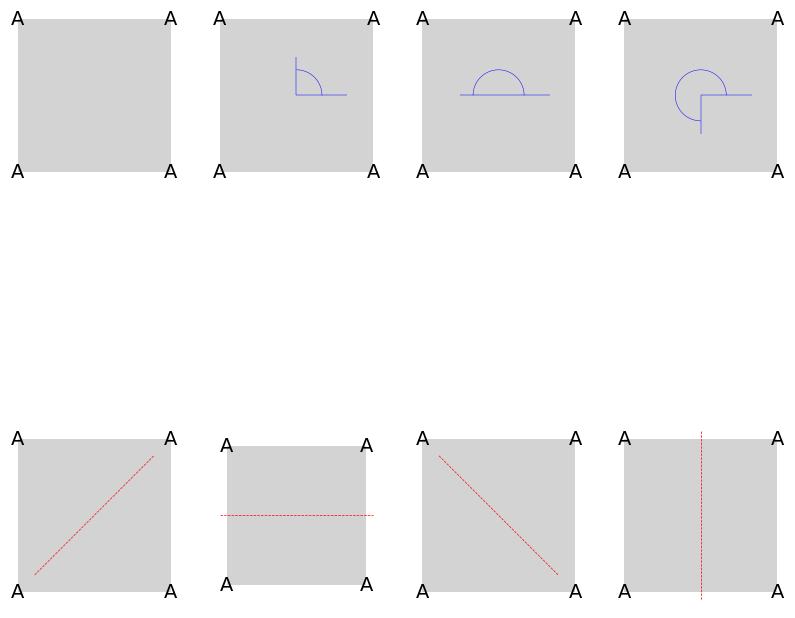

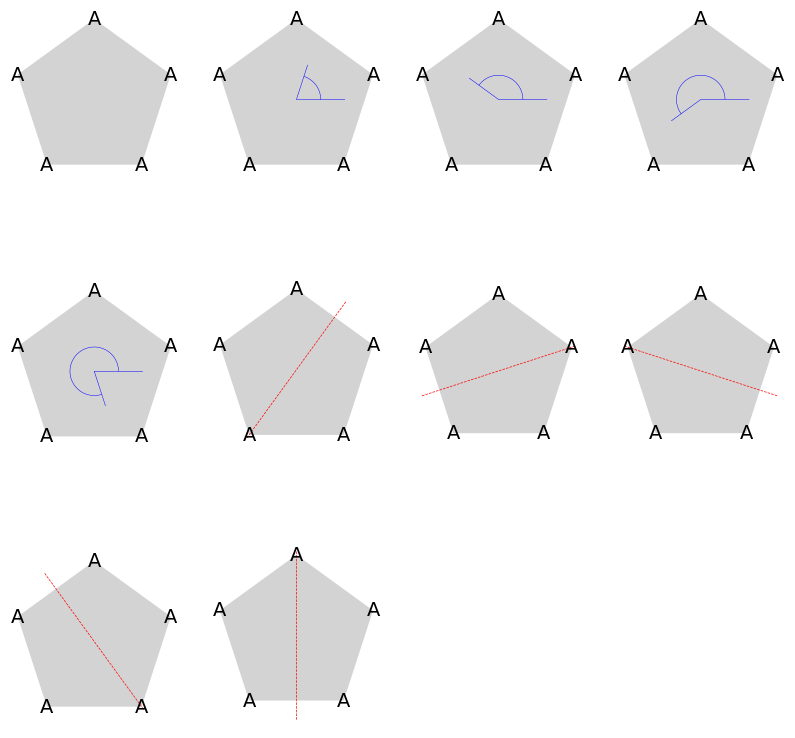

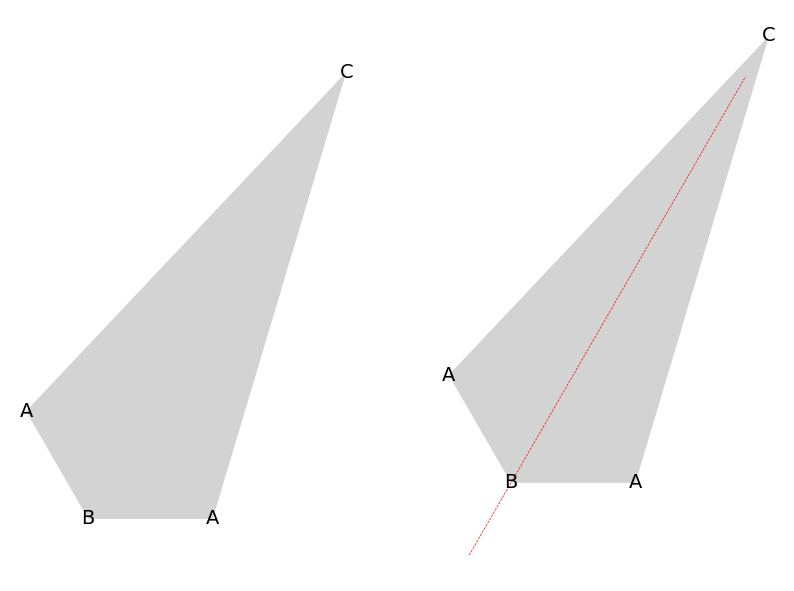

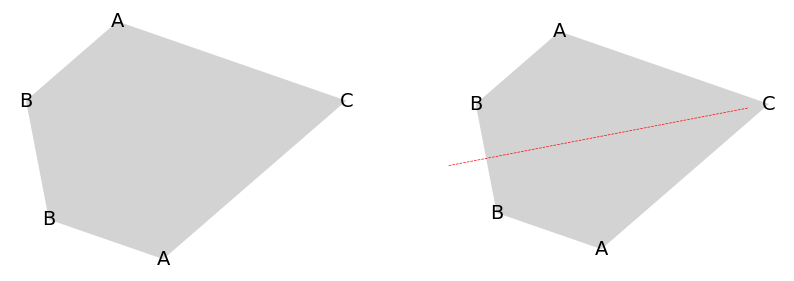

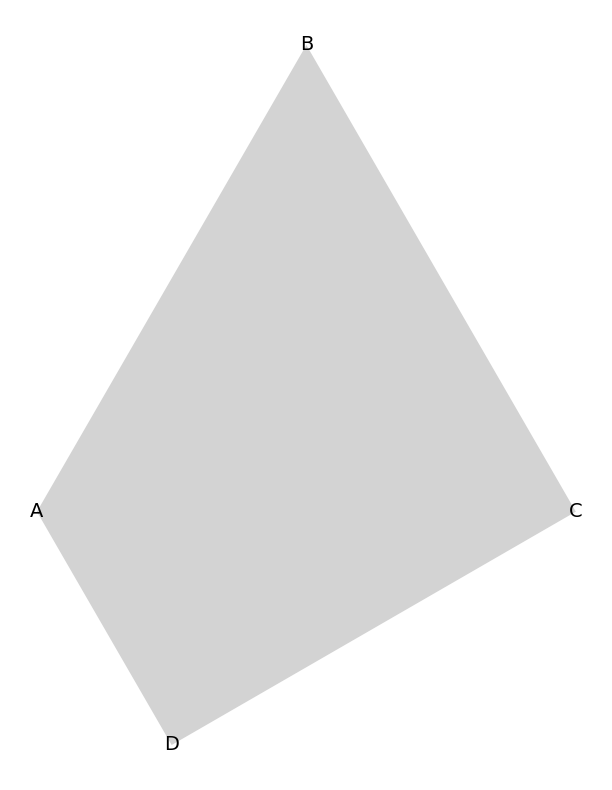

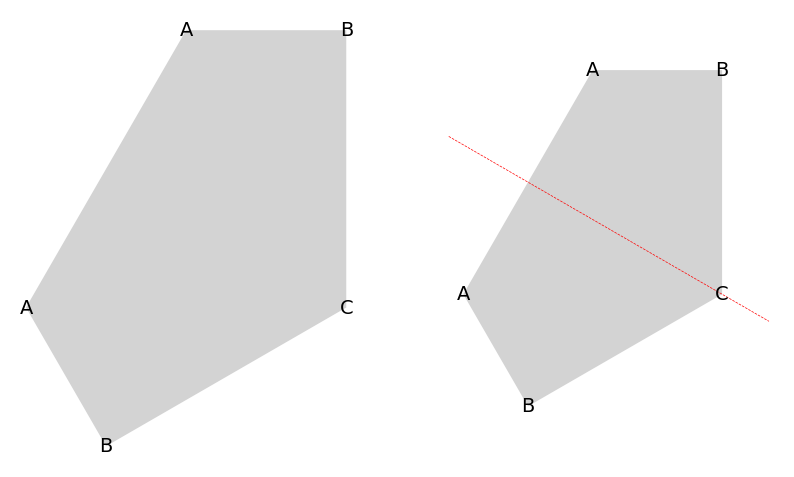

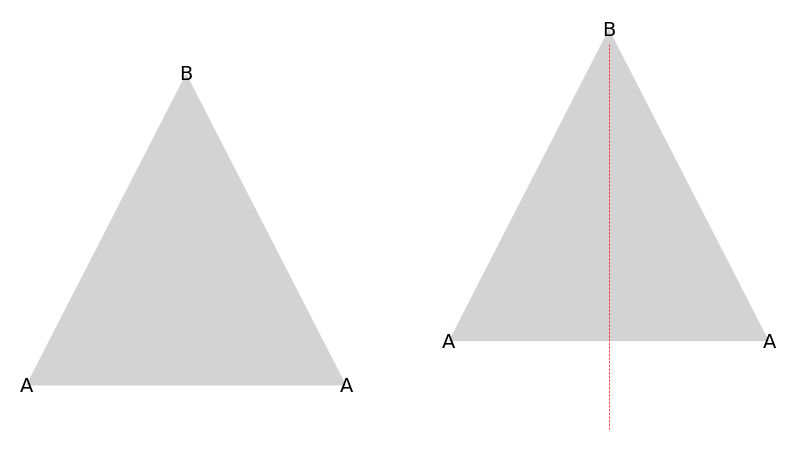

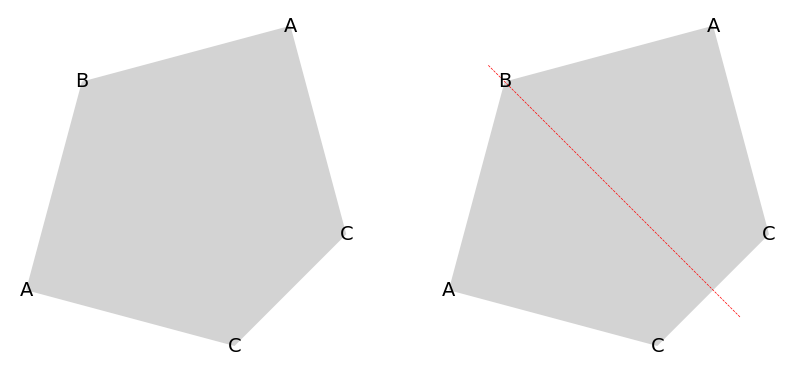

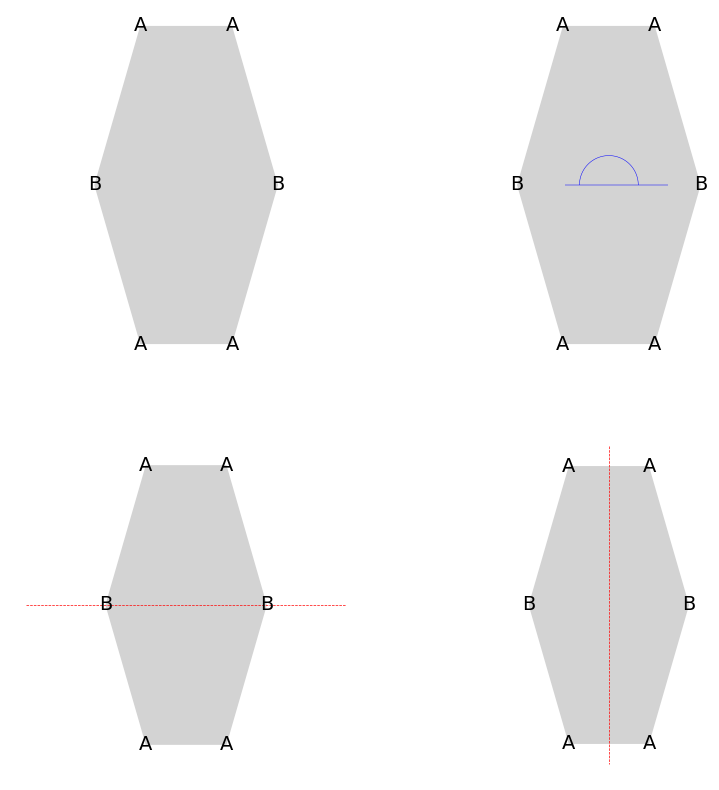

In [18]:
symmetries = [Symmetries(p) for p in polys]
for s in symmetries:
  s.plot()